In [1]:
from copy import deepcopy
import json
import glob
import os
import sys
import time
import argparse
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.font_manager import FontProperties
import cv2
import pandas as pd

In [2]:
iou_thr = 0.5

In [3]:
main_dir = os.path.dirname(os.getcwd())

In [4]:
sys.path.append(os.path.join(main_dir, 'average_precision/'))

In [5]:
from calculate_mean_ap import get_avg_precision_at_iou, plot_pr_curve, simple_precision_recall

In [6]:
ground_truth_boxes = '/home/vgoncalves/personal-git/people-detection-compare/resources/virat_dataset/VIRAT_videos_moving_ground_truth_boxes.json'

In [7]:
with open(ground_truth_boxes) as infile:
    gt_boxes = json.load(infile)

In [8]:
COLORS = [
    '#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c',
    '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5',
    '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f',
    '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5']

## Dataset description

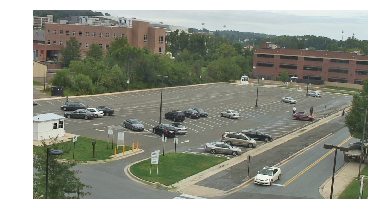

981


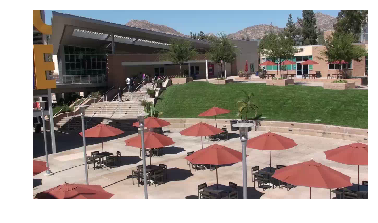

3956


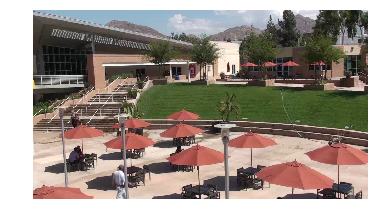

534


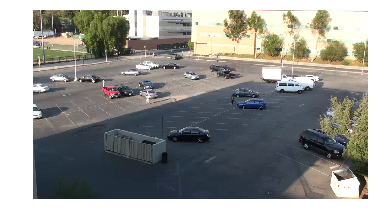

609


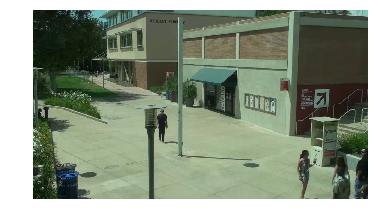

2091


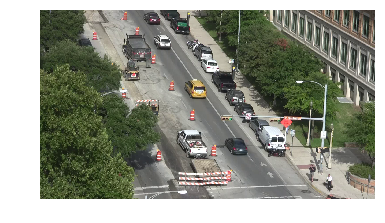

834


In [9]:
videos_path = os.path.join(main_dir, 'resources/virat_dataset/')

video_name_list = ['VIRAT_S_000201_02_000590_000623',
                   'VIRAT_S_010000_00_000000_000165',
                   'VIRAT_S_010003_01_000111_000137',
                   'VIRAT_S_010106_01_000493_000526',
                   'VIRAT_S_010200_03_000470_000567',
                   'VIRAT_S_050000_12_001591_001619']

video_dict = {}
total_frames_all_videos = 0
plt.clf()
#plt.rcParams['figure.figsize'] = [30, 15]


for video_name in video_name_list:
    video_file_path = os.path.join(videos_path,video_name +  '.mp4')
    vs = cv2.VideoCapture(video_file_path)  # Video
    num_frames = int(vs.get(cv2.CAP_PROP_FRAME_COUNT))
    total_frames_all_videos += num_frames
    success, frame = vs.read()
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
    print(num_frames)

In [10]:
total_frames_all_videos

9005

In [11]:
## Count labeled frames
all_ground_truth_boxes = '/home/vgoncalves/personal-git/people-detection-compare/resources/virat_dataset/VIRAT_videos_ground_truth_boxes.json'
with open(all_ground_truth_boxes) as infile:
    all_gt_boxes = json.load(infile)
    
counter = 0 
total = 0 
for key, value in all_gt_boxes.items():
    total += 1
    if len(value) != 0:
        counter += 1

In [12]:
counter

8668

In [13]:
total

9005

In [14]:
total_movement = 0
for key in gt_boxes.keys():
    total_movement += 1

In [15]:
total_movement

8522

In [16]:
##Precison - Recall only

In [22]:
for technique in ['haar', 'hog','mobile_ssd','yolo']:
    dict_map = {}

    filtered_files = [file for file in os.listdir(os.path.join(main_dir, 'results/')) if technique in file]
    names = [file.strip('VIRAT_videos_').strip('_FPS.txt') for file in filtered_files if 'FPS' in file]
    names.sort() 

    ax = None
    for idx, name in enumerate(names):
        if 'tiled' in name:
            type_tile  = name[-3:]
        else:
            type_tile = 'No tiles'

        predicted_boxes = os.path.join(main_dir, 'results/VIRAT_videos_' + name + '_moving_predicted_boxes.json')
        with open(predicted_boxes) as infile:
            pred_boxes = json.load(infile)

        prec, rec = simple_precision_recall(gt_boxes, pred_boxes, iou_thr=iou_thr)
        precision = np.round(prec * 100, 2)
        recall = np.round(rec * 100, 2)
        f1_score = 2 * ((precision*recall)/(precision+recall))
        print(name, 'Precision', precision, 'Recall', recall, 'F1 Score', np.round(f1_score, 2))

haar Precision 43.23 Recall 7.82 F1 Score 13.24
haar_tiled_2X3 Precision 19.27 Recall 10.39 F1 Score 13.5
hog Precision 9.87 Recall 7.51 F1 Score 8.53
hog_tiled_2X3 Precision 4.45 Recall 8.5 F1 Score 5.84
mobile_ssd Precision 58.08 Recall 1.3 F1 Score 2.54
mobile_ssd_tiled_2X3 Precision 52.61 Recall 10.69 F1 Score 17.77
mobile_ssd_tiled_3X4 Precision 48.61 Recall 15.73 F1 Score 23.77
mobile_ssd_tiled_4X5 Precision 46.03 Recall 21.89 F1 Score 29.67
mobile_ssd_tiled_5X6 Precision 43.29 Recall 27.72 F1 Score 33.8
mobile_ssd_tiled_6X7 Precision 39.75 Recall 28.94 F1 Score 33.49
yolo Precision 0.54 Recall 0.03 F1 Score 0.06
yolo_tiled_2X3 Precision 5.81 Recall 3.57 F1 Score 4.42
yolo_tiled_3X4 Precision 9.67 Recall 7.5 F1 Score 8.45
yolo_tiled_4X5 Precision 12.28 Recall 9.16 F1 Score 10.49
yolo_tiled_5X6 Precision 14.17 Recall 11.42 F1 Score 12.65
yolo_tiled_6X7 Precision 15.24 Recall 12.57 F1 Score 13.78


In [10]:
names

['yolo',
 'yolo_tiled_2X3',
 'yolo_tiled_3X4',
 'yolo_tiled_4X5',
 'yolo_tiled_5X6',
 'yolo_tiled_6X7']

In [12]:
prec, rec

(0.005431093007467753, 0.00034105684991367)

## PR Curve

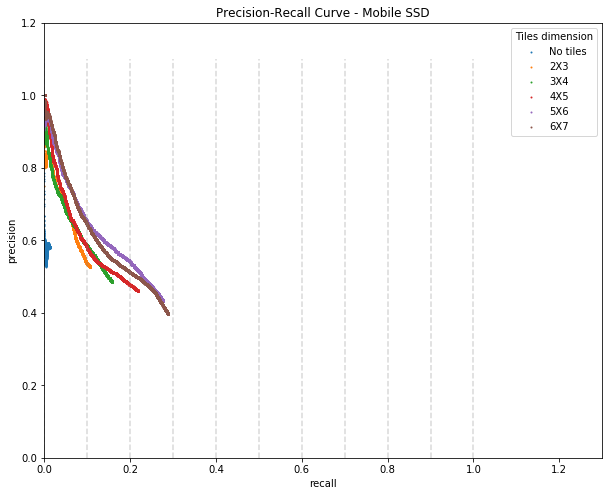

In [9]:
technique = 'mobile_ssd'
dict_map = {}

filtered_files = [file for file in os.listdir(os.path.join(main_dir, 'results/')) if technique in file]
names = [file.strip('VIRAT_videos_').strip('_FPS.txt') for file in filtered_files if 'FPS' in file]
names.sort() 

ax = None
for idx, name in enumerate(names):
    if 'tiled' in name:
        type_tile  = name[-3:]
    else:
        type_tile = 'No tiles'
        
    predicted_boxes = os.path.join(main_dir, 'results/VIRAT_videos_' + name + '_moving_predicted_boxes.json')
    with open(predicted_boxes) as infile:
        pred_boxes = json.load(infile)
    
    data = get_avg_precision_at_iou(gt_boxes, pred_boxes, iou_thr=iou_thr)
    dict_map[name] = data['avg_prec']
    
    ax = plot_pr_curve(data['precisions'], data['recalls'], label=type_tile, title='Precision-Recall Curve - Mobile SSD', color=COLORS[idx*2], ax=ax)

plt.legend(loc='upper right', title='Tiles dimension', frameon=True)
for xval in np.linspace(0.0, 1.0, 11):
    plt.vlines(xval, 0.0, 1.1, color='gray', alpha=0.3, linestyles='dashed')
plt.show()    

    

In [9]:
technique = 'mobile_ssd'
dict_map = {}

filtered_files = [file for file in os.listdir(os.path.join(main_dir, 'results/')) if technique in file]
names = [file.strip('VIRAT_videos_').strip('_FPS.txt') for file in filtered_files if 'FPS' in file]
names.sort() 


In [10]:
names

['mobile_ssd',
 'mobile_ssd_tiled_2X3',
 'mobile_ssd_tiled_3X4',
 'mobile_ssd_tiled_4X5',
 'mobile_ssd_tiled_5X6',
 'mobile_ssd_tiled_6X7']

In [12]:
predicted_boxes = os.path.join(main_dir, 'results/VIRAT_videos_mobile_ssd_moving_predicted_boxes.json')

In [13]:
with open(predicted_boxes) as infile:
        pred_boxes = json.load(infile)

In [15]:
data = get_avg_precision_at_iou(gt_boxes, pred_boxes, iou_thr=iou_thr)

In [16]:
data

{'avg_prec': 0.09090909090909091,
 'model_thrs': [0.2510074973106384,
  0.25135985016822815,
  0.2514517903327942,
  0.2515406310558319,
  0.2526988983154297,
  0.253134548664093,
  0.25349366664886475,
  0.25356969237327576,
  0.253737211227417,
  0.25496023893356323,
  0.2554180324077606,
  0.2556905448436737,
  0.25639161467552185,
  0.2569342851638794,
  0.25790297985076904,
  0.2581414580345154,
  0.2582542598247528,
  0.2585786283016205,
  0.25859078764915466,
  0.25899970531463623,
  0.2590818703174591,
  0.2595890760421753,
  0.2598753571510315,
  0.26187095046043396,
  0.26197218894958496,
  0.262250155210495,
  0.26257890462875366,
  0.2629954218864441,
  0.26312780380249023,
  0.26324889063835144,
  0.26341864466667175,
  0.2637331783771515,
  0.26385197043418884,
  0.2638860046863556,
  0.26402559876441956,
  0.2641848921775818,
  0.2643556296825409,
  0.26438960433006287,
  0.26469409465789795,
  0.2649853229522705,
  0.2653304934501648,
  0.26565980911254883,
  0.26570504

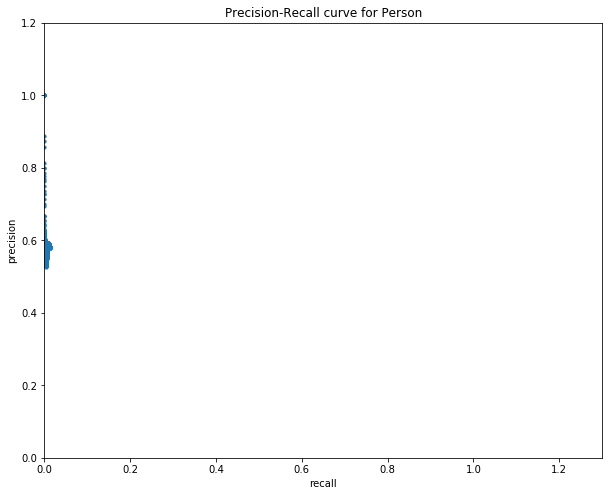

In [20]:
ax = None
ax = plot_pr_curve(data['precisions'], data['recalls'], color=COLORS[0*2], ax=ax)

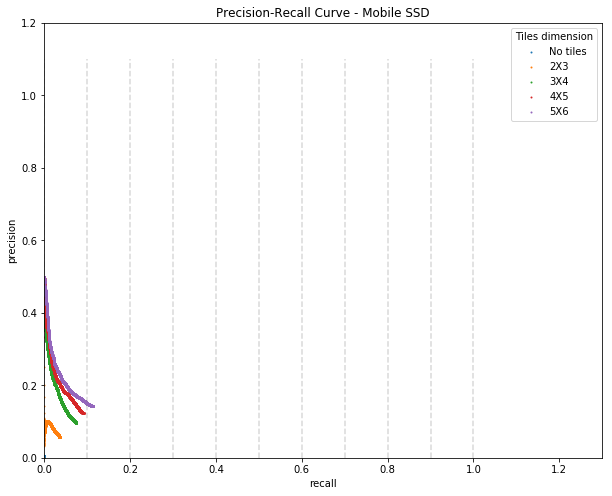

In [152]:
technique = 'yolo'
dict_map = {}

filtered_files = [file for file in os.listdir(os.path.join(main_dir, 'results/')) if technique in file]
names = [file.strip('VIRAT_videos_').strip('_FPS.txt') for file in filtered_files if 'FPS' in file]
names.sort() 

ax = None
for idx, name in enumerate(names):
    if 'tiled' in name:
        type_tile  = name[-3:]
    else:
        type_tile = 'No tiles'
        
    predicted_boxes = os.path.join(main_dir, 'results/VIRAT_videos_' + name + '_moving_predicted_boxes.json')
    with open(predicted_boxes) as infile:
        pred_boxes = json.load(infile)
    
    data = get_avg_precision_at_iou(gt_boxes, pred_boxes, iou_thr=iou_thr)
    dict_map[name] = data['avg_prec']
    
    ax = plot_pr_curve(data['precisions'], data['recalls'], label=type_tile, title='Precision-Recall Curve - Mobile SSD', color=COLORS[idx*2], ax=ax)

plt.legend(loc='upper right', title='Tiles dimension', frameon=True)
for xval in np.linspace(0.0, 1.0, 11):
    plt.vlines(xval, 0.0, 1.1, color='gray', alpha=0.3, linestyles='dashed')
plt.show()   

In [9]:
technique = 'haar_confidence'
dict_map = {}

filtered_files = [file for file in os.listdir(os.path.join(main_dir, 'results/')) if technique in file]
names = [file.strip('VIRAT_videos_').strip('_FPS.txt') for file in filtered_files if 'FPS' in file]
names.sort() 

ax = None
for idx, name in enumerate(names):
    if 'tiled' in name:
        type_tile  = name[-3:]
    else:
        type_tile = 'No tiles'
        
    predicted_boxes = os.path.join(main_dir, 'results/VIRAT_videos_' + name + '_moving_predicted_boxes.json')
    with open(predicted_boxes) as infile:
        pred_boxes = json.load(infile)
    
    data = get_avg_precision_at_iou(gt_boxes, pred_boxes, iou_thr=iou_thr, scores_all_same=True)
    dict_map[name] = data['avg_prec']
    
    ax = plot_pr_curve(data['precisions'], data['recalls'], label=type_tile, title='Precision-Recall Curve - Mobile SSD', color=COLORS[idx*2], ax=ax)

plt.legend(loc='upper right', title='Tiles dimension', frameon=True)
for xval in np.linspace(0.0, 1.0, 11):
    plt.vlines(xval, 0.0, 1.1, color='gray', alpha=0.3, linestyles='dashed')
plt.show() 

FileNotFoundError: [Errno 2] No such file or directory: '/home/vgoncalves/personal-git/people-detection-compare/results/VIRAT_videos_haar_confidence_moving_predicted_boxes.json'

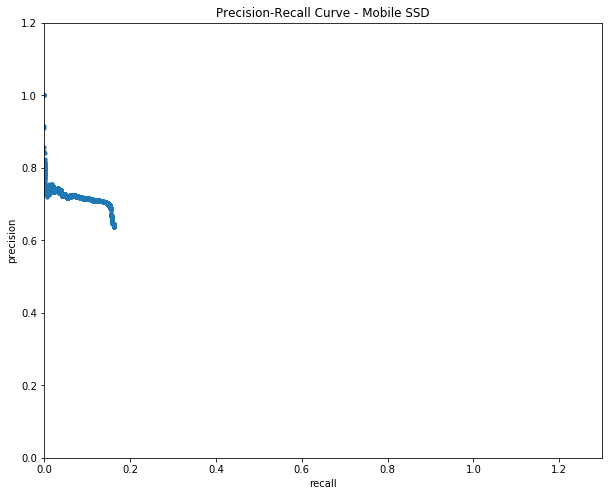

In [22]:
name = 'haar_confidence'
predicted_boxes = os.path.join(main_dir, 'results/VIRAT_videos_haar_confidence_predicted_boxes.json')
with open(predicted_boxes) as infile:
    pred_boxes = json.load(infile)
ground_truth_boxes = os.path.join(main_dir, 'resources/virat_dataset/VIRAT_videos_ground_truth_boxes_test.json')

with open(ground_truth_boxes) as infile:
    gt_boxes = json.load(infile)
    
data = get_avg_precision_at_iou(gt_boxes, pred_boxes, iou_thr=iou_thr)
dict_map[name] = data['avg_prec']

ax = None
ax = plot_pr_curve(data['precisions'], data['recalls'], label=type_tile, title='Precision-Recall Curve - Mobile SSD', color=COLORS[idx*2], ax=ax)

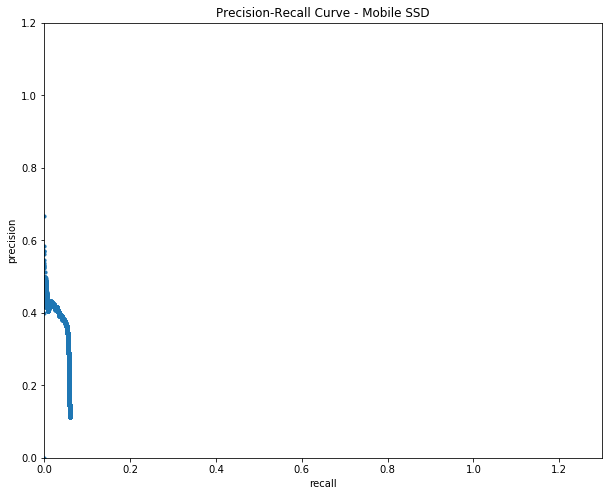

In [24]:
name = 'hog_confidence'
predicted_boxes = os.path.join(main_dir, 'results/VIRAT_videos_hog_confidence_predicted_boxes.json')
with open(predicted_boxes) as infile:
    pred_boxes = json.load(infile)
ground_truth_boxes = os.path.join(main_dir, 'resources/virat_dataset/VIRAT_videos_ground_truth_boxes_test.json')

with open(ground_truth_boxes) as infile:
    gt_boxes = json.load(infile)
    
data = get_avg_precision_at_iou(gt_boxes, pred_boxes, iou_thr=iou_thr)
dict_map[name] = data['avg_prec']

ax = None
ax = plot_pr_curve(data['precisions'], data['recalls'], label=type_tile, title='Precision-Recall Curve - Mobile SSD', color=COLORS[idx*2], ax=ax)

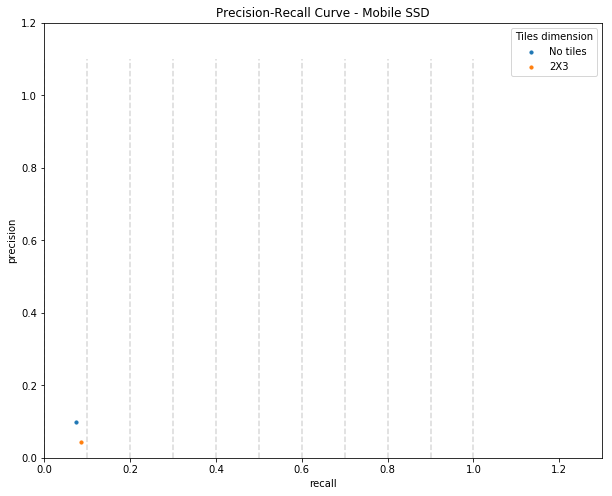

In [10]:
technique = 'hog'
dict_map = {}

filtered_files = [file for file in os.listdir(os.path.join(main_dir, 'results/')) if technique in file]
names = [file.strip('VIRAT_videos_').strip('_FPS.txt') for file in filtered_files if 'FPS' in file]
names.sort() 

ax = None
for idx, name in enumerate(names):
    if 'tiled' in name:
        type_tile  = name[-3:]
    else:
        type_tile = 'No tiles'
        
    predicted_boxes = os.path.join(main_dir, 'results/VIRAT_videos_' + name + '_moving_predicted_boxes.json')
    with open(predicted_boxes) as infile:
        pred_boxes = json.load(infile)
    
    data = get_avg_precision_at_iou(gt_boxes, pred_boxes, iou_thr=iou_thr, scores_all_same=True)
    dict_map[name] = data['avg_prec']
    
    ax = plot_pr_curve(data['precisions'], data['recalls'], label=type_tile, title='Precision-Recall Curve - Mobile SSD', color=COLORS[idx*2], ax=ax)

plt.legend(loc='upper right', title='Tiles dimension', frameon=True)
for xval in np.linspace(0.0, 1.0, 11):
    plt.vlines(xval, 0.0, 1.1, color='gray', alpha=0.3, linestyles='dashed')
plt.show() 

## mAP

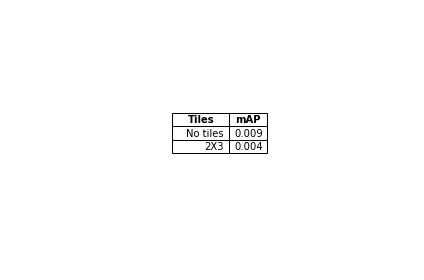

In [18]:
columns = (['Tiles','mAP'])

cell_text = []
for idx, name in enumerate(names):
    if 'tiled' in name:
        type_tile  = name[-3:]
    else:
        type_tile = 'No tiles'
        
    cell_text.append([type_tile,'%1.3f' % dict_map[name]])
    
plt.clf()
fig, ax = plt.subplots()
#fig.patch.set_visible(False)
ax.axis('off')
#ax.axis('tight')

table = ax.table(cellText=cell_text, colLabels=columns, loc='center', colWidths=[0.15,0.1], label='Mean Avg')

for (row, col), cell in table.get_celld().items():
    if (row == 0):
        cell.set_text_props(fontproperties=FontProperties(weight='bold'))

fig.tight_layout()
##plt.xlabel("Mobile SSD mean Average Precision")

plt.show()


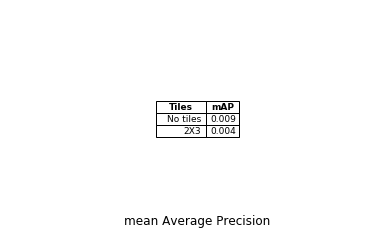

In [32]:
columns = (['Tiles','mAP'])

cell_text = []
for idx, name in enumerate(names):
    if 'tiled' in name:
        type_tile  = name[-3:]
    else:
        type_tile = 'No tiles'
        
    cell_text.append([type_tile,'%1.3f' % dict_map[name]])
    
plt.clf()
#fig, ax = plt.subplots()
#fig.patch.set_visible(False)
#ax.axis('off')
#ax.axis('tight')

table = plt.table(cellText=cell_text, colLabels=columns, loc='center', colWidths=[0.15,0.1], label='Mean Avg')

for (row, col), cell in table.get_celld().items():
    if (row == 0):
        cell.set_text_props(fontproperties=FontProperties(weight='bold'))

#fig.tight_layout()
##plt.xlabel("Mobile SSD mean Average Precision")
#plt.legend('JI')
#table.show()
plt.axis('off')
plt.title('mean Average Precision', y=-0.01)
plt.show()


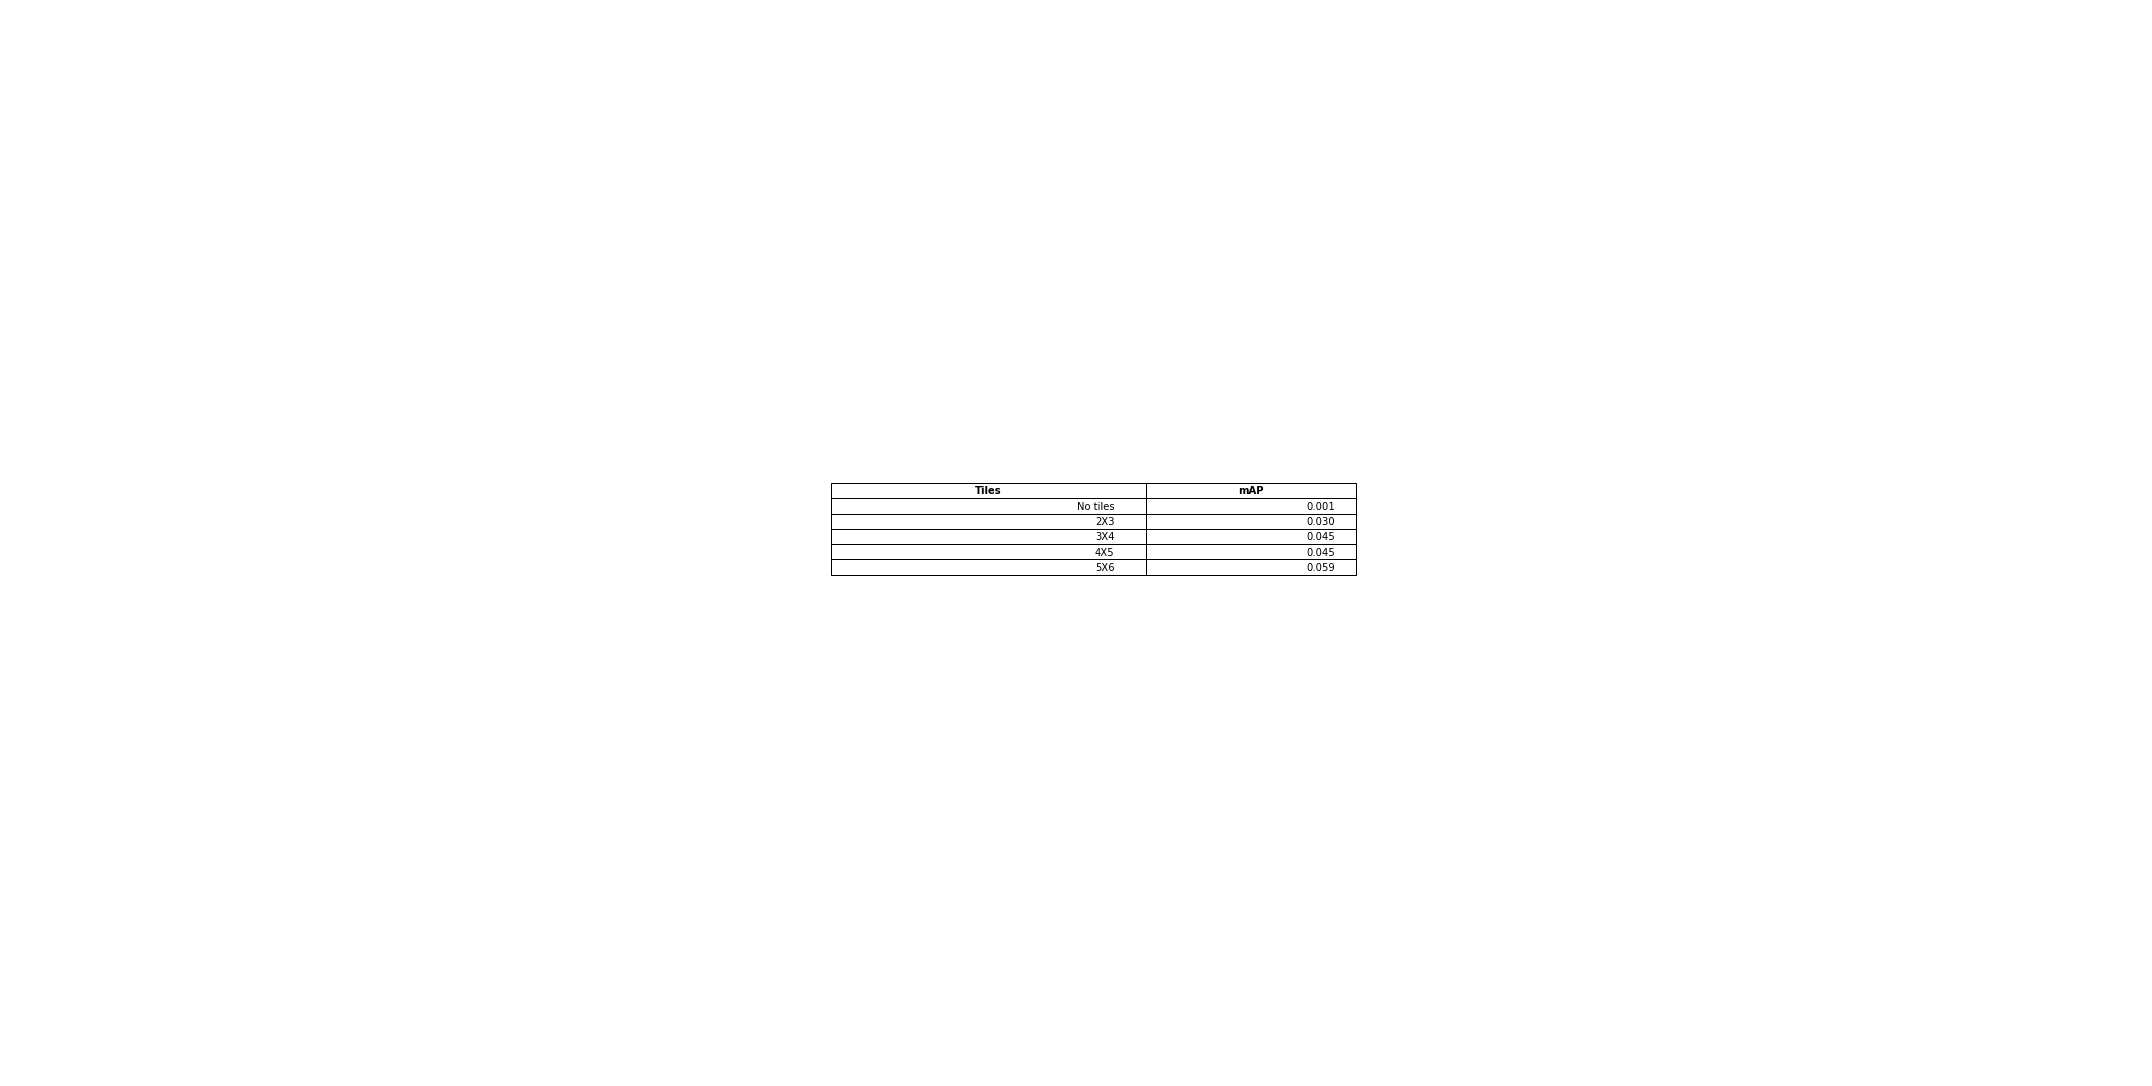

In [155]:
columns = (['Tiles','mAP'])

cell_text = []
for idx, name in enumerate(names):
    if 'tiled' in name:
        type_tile  = name[-3:]
    else:
        type_tile = 'No tiles'
        
    cell_text.append([type_tile,'%1.3f' % dict_map[name]])
    
plt.clf()
fig, ax = plt.subplots()
#fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

table = ax.table(cellText=cell_text, colLabels=columns, loc='center', colWidths=[0.15,0.1])

for (row, col), cell in table.get_celld().items():
    if (row == 0):
        cell.set_text_props(fontproperties=FontProperties(weight='bold'))

fig.tight_layout()
plt.xlabel("Mobile SSD mean Average Precision")

plt.show()


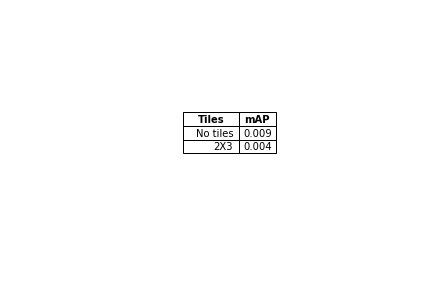

In [11]:
columns = (['Tiles','mAP'])

cell_text = []
for idx, name in enumerate(names):
    if 'tiled' in name:
        type_tile  = name[-3:]
    else:
        type_tile = 'No tiles'
        
    cell_text.append([type_tile,'%1.3f' % dict_map[name]])
    
plt.clf()
fig, ax = plt.subplots()
#fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

table = ax.table(cellText=cell_text, colLabels=columns, loc='center', colWidths=[0.15,0.1])

for (row, col), cell in table.get_celld().items():
    if (row == 0):
        cell.set_text_props(fontproperties=FontProperties(weight='bold'))

fig.tight_layout()
plt.xlabel("Mobile SSD mean Average Precision")

plt.show()


## FPS

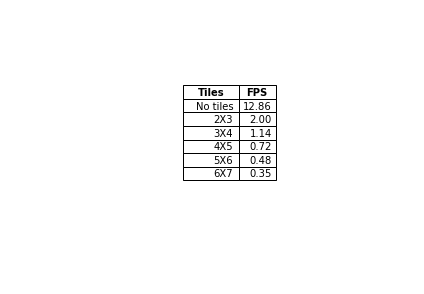

In [85]:
columns = (['Tiles','FPS'])

cell_text = []
for idx, name in enumerate(names):
    if 'tiled' in name:
        type_tile  = name[-3:]
    else:
        type_tile = 'No tiles'
    
    file  = os.path.join(main_dir, 'results/VIRAT_videos_' + name + '_FPS.txt')  
    value = np.loadtxt(file)
    cell_text.append([type_tile,'%1.2f' % value])
    
plt.clf()
fig, ax = plt.subplots()
#fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

table = ax.table(cellText=cell_text, colLabels=columns, loc='center', colWidths=[0.15,0.1])

for (row, col), cell in table.get_celld().items():
    if (row == 0):
        cell.set_text_props(fontproperties=FontProperties(weight='bold'))

fig.tight_layout()
plt.xlabel("Mobile SSD Frames per Second")

plt.show()

## CPU USAGE

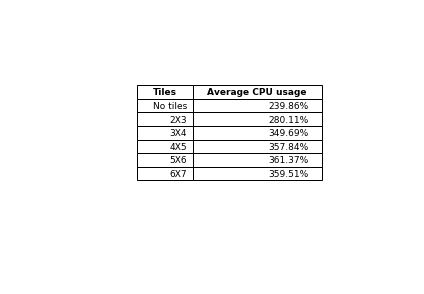

In [93]:
columns = (['Tiles','Average CPU usage'])

cell_text = []
for idx, name in enumerate(names):
    if 'tiled' in name:
        type_tile  = name[-3:]
    else:
        type_tile = 'No tiles'
    
    file  = os.path.join(main_dir, 'results/VIRAT_videos_' + name + '_AVG_CPU.txt')  
    value = np.loadtxt(file)
    cell_text.append([type_tile,'%1.2f%%' % value])
    
plt.clf()
fig, ax = plt.subplots()
#fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

table = ax.table(cellText=cell_text, colLabels=columns, loc='center', colWidths=[0.15,0.35])

for (row, col), cell in table.get_celld().items():
    if (row == 0):
        cell.set_text_props(fontproperties=FontProperties(weight='bold'))

fig.tight_layout()
plt.xlabel("Mobile SSD Frames per Second")

plt.show()

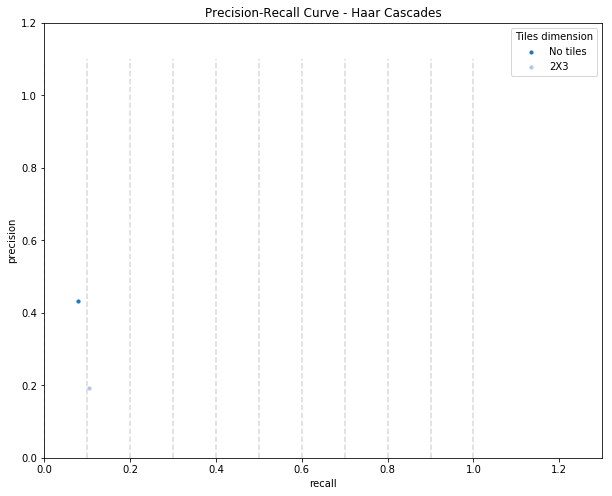

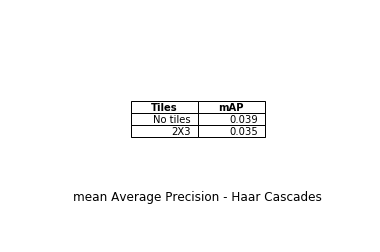

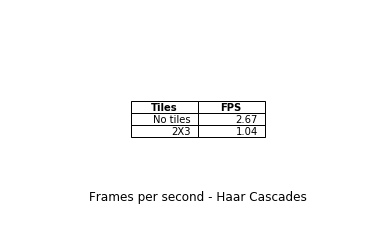

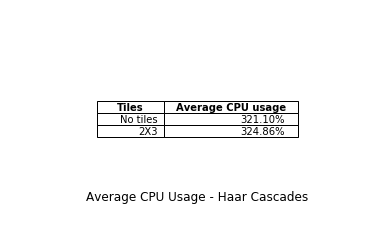

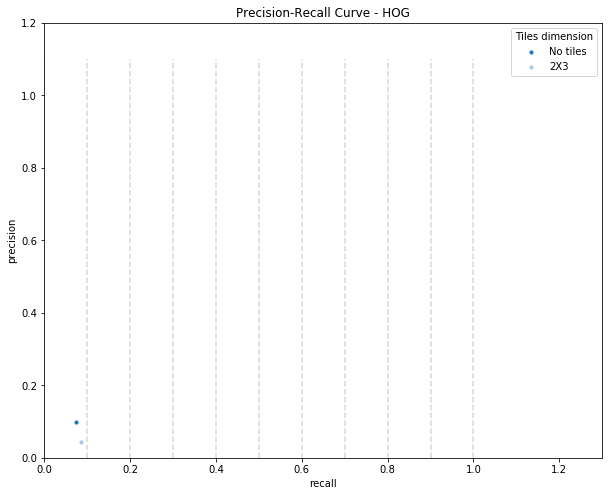

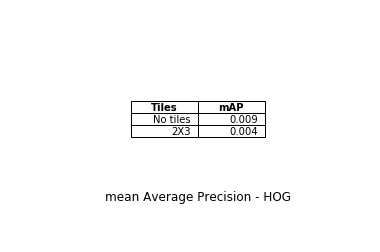

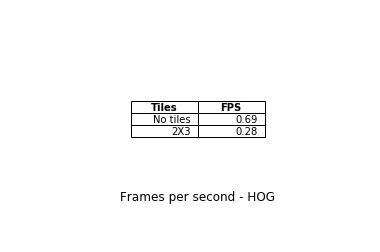

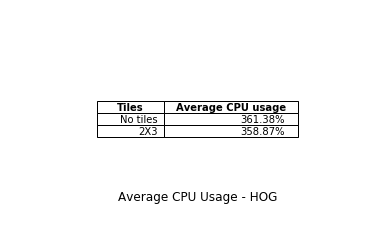

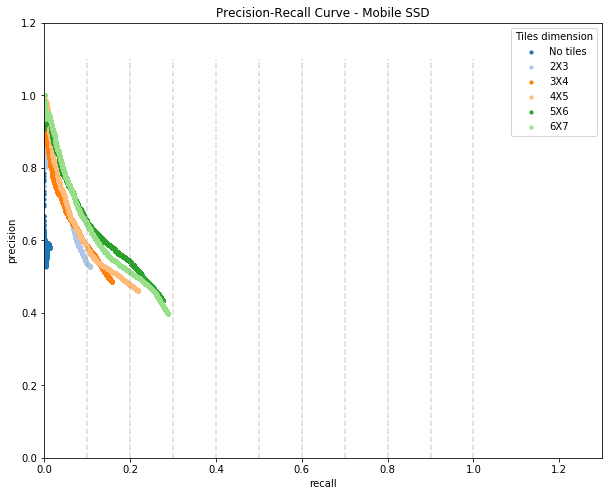

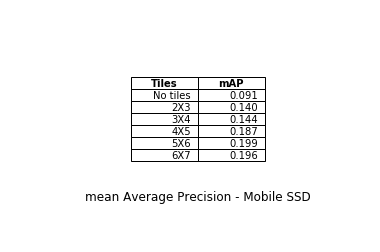

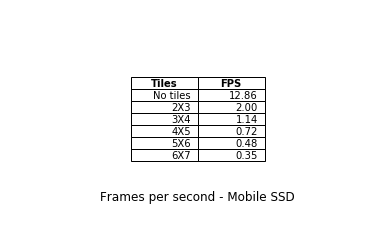

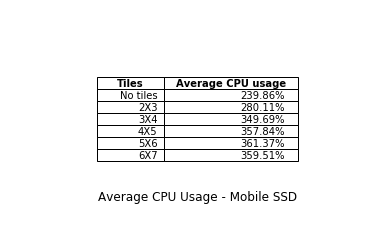

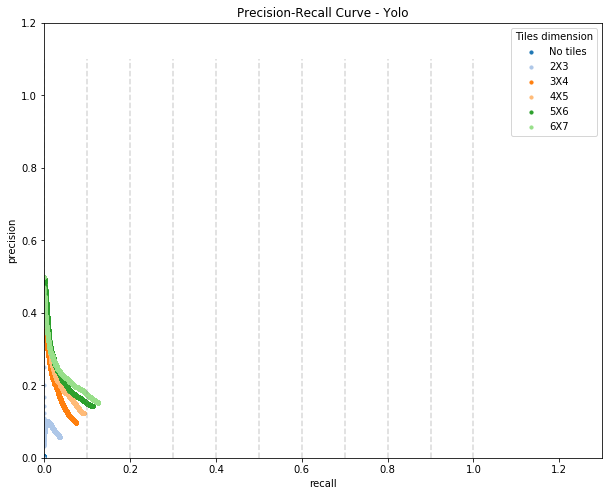

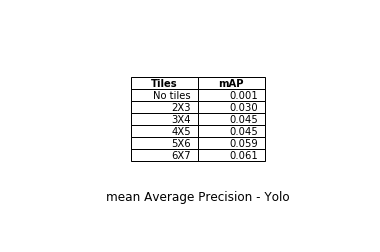

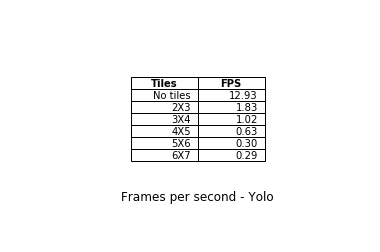

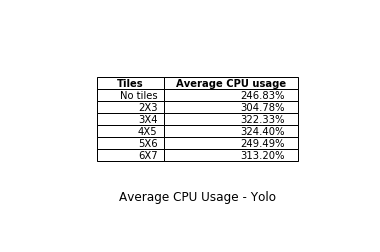

In [42]:
iou_thr = 0.5

beautify_title_dict  = {'haar': 'Haar Cascades',
                       'hog': 'HOG',
                       'mobile_ssd':'Mobile SSD',
                       'yolo': 'Yolo'}
for technique in ['haar', 'hog','mobile_ssd','yolo']:
    ############ Precison-Recall Curve ############
    dict_map = {}

    filtered_files = [file for file in os.listdir(os.path.join(main_dir, 'results/')) if technique in file]
    names = [file.strip('VIRAT_videos_').strip('_FPS.txt') for file in filtered_files if 'FPS' in file]
    names.sort() 

    ax = None
    for idx, name in enumerate(names):
        if 'tiled' in name:
            type_tile  = name[-3:]
        else:
            type_tile = 'No tiles'

        predicted_boxes = os.path.join(main_dir, 'results/VIRAT_videos_' + name + '_moving_predicted_boxes.json')
        with open(predicted_boxes) as infile:
            pred_boxes = json.load(infile)

        if technique == 'haar' or technique == 'hog':
            data = get_avg_precision_at_iou(gt_boxes, pred_boxes, iou_thr=iou_thr, scores_all_same=True)
        else:
            data = get_avg_precision_at_iou(gt_boxes, pred_boxes, iou_thr=iou_thr)
            
        dict_map[name] = data['avg_prec']

        ax = plot_pr_curve(data['precisions'], data['recalls'], label=type_tile, title='Precision-Recall Curve - ' + beautify_title_dict[technique], color=COLORS[idx], ax=ax)

    plt.legend(loc='upper right', title='Tiles dimension', frameon=True)
    for xval in np.linspace(0.0, 1.0, 11):
        plt.vlines(xval, 0.0, 1.1, color='gray', alpha=0.3, linestyles='dashed')
    plt.show()   
    
    ########### mAP ############
    plt.clf()
    columns = (['Tiles','mAP'])
    cell_text = []
    for idx, name in enumerate(names):
        if 'tiled' in name:
            type_tile  = name[-3:]
        else:
            type_tile = 'No tiles'

        cell_text.append([type_tile,'%1.3f' % dict_map[name]])

    table = plt.table(cellText=cell_text, colLabels=columns, loc='center', colWidths=[0.2,0.2])

    for (row, col), cell in table.get_celld().items():
        if (row == 0):
            cell.set_text_props(fontproperties=FontProperties(weight='bold'))

    plt.axis('off')
    plt.title('mean Average Precision - ' + beautify_title_dict[technique], y=0.1)
    plt.show()
    
    
    ########### FPS ############
    plt.clf()
    columns = (['Tiles','FPS'])

    cell_text = []
    for idx, name in enumerate(names):
        if 'tiled' in name:
            type_tile  = name[-3:]
        else:
            type_tile = 'No tiles'

        file  = os.path.join(main_dir, 'results/VIRAT_videos_' + name + '_FPS.txt')  
        value = np.loadtxt(file)
        cell_text.append([type_tile,'%1.2f' % value])



    table = plt.table(cellText=cell_text, colLabels=columns, loc='center', colWidths=[0.2,0.2])

    for (row, col), cell in table.get_celld().items():
        if (row == 0):
            cell.set_text_props(fontproperties=FontProperties(weight='bold'))
    
    plt.axis('off')
    plt.title('Frames per second - ' + beautify_title_dict[technique], y=0.1)
    plt.show()
    
    
    ########### FPS ############
    plt.clf()
    columns = (['Tiles','Average CPU usage'])

    cell_text = []
    for idx, name in enumerate(names):
        if 'tiled' in name:
            type_tile  = name[-3:]
        else:
            type_tile = 'No tiles'

        file  = os.path.join(main_dir, 'results/VIRAT_videos_' + name + '_AVG_CPU.txt')  
        value = np.loadtxt(file)
        cell_text.append([type_tile,'%1.2f%%' % value])


    table = plt.table(cellText=cell_text, colLabels=columns, loc='center', colWidths=[0.2,0.4])

    for (row, col), cell in table.get_celld().items():
        if (row == 0):
            cell.set_text_props(fontproperties=FontProperties(weight='bold'))

    plt.axis('off')
    plt.title('Average CPU Usage - ' + beautify_title_dict[technique], y=0.1)
    plt.show()


    